# Satellite cloud cover validation for energy budget analysis

Production date: 15-10-2024

Produced by: CNRS

## 🌍 Use case: Detection of changes in the latitudinal position of cloudiest and clearest regions

## ❓ Quality assessment question:
 - __Which satellite dataset provides the lowest uncertainty in latitudinal cloud fraction?__



Clouds are fundamental regulators of the Earth's climate system, significantly influencing the planet's radiative budget, hydrological cycle, and global circulation. These factors, in turn, play a crucial role in shaping ecosystems, agriculture, water resources, and weather patterns. The overall impact of clouds on Earth's climate is determined by various properties, including cloud amount, height, thickness, and microphysical characteristics. Given their substantial influence on climate, cloud properties are extensively studied, both in the present context and in relation to their evolution under climate change.
The following notebook focuses on the cloud amount, which strongly impacts the Earth's climate. A large cloud cover can lead to increased albedo, reflecting more sunlight back into space, which can cool the surface. Conversely, a small amount of clouds may result in enhanced solar radiation reaching the Earth's surface, leading to higher temperatures and altered precipitation patterns.

This analysis utilizes cloud observations from the dataset [__Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations__](https://cds-beta.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview), derived from satellite observations and available through the Climate Data Store. The cloud properties in this dataset are provided by three distinct products, categorized into two main families.
The CLARA (CM SAF cLoud, Albedo and surface Radiation) product family includes two retrieval versions applied on AVHRR (Advanced Very High Resolution Radiometer) observations, CLARA-A2 and CLARA-A3. The CCI (Climate Change Initiative) product family is represented by a single product derived from ATSR (Along Track Scanning Radiometer) and SLSTR (Sea and Land Surface Temperature Radiometer). 


The three datasets, CLARA-A2, CLARA-A3, and CCI, use distinct methods to retrieve cloud properties. This notebook presents a comparative analysis of the cloud cover estimates from these datasets, both among themselves and against other satellite data [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). Additionally, it includes a discussion on the comparisons and uncertainty estimates.


## 📢 Quality assessment statement 

These are the key outcomes of this assessment:


- Zonal mean cloud cover is consistent across the three datasets, as the values fall within the uncertainty ranges. In general, CLARA-A3 provides the largest cloud cover and CCI the smallest one, with a difference of approximately 4%.

- CLARA-A2 does not provide uncertainty estimates for cloud cover observations. The cloud cover uncertainty of CLARA-A3 varies between 5 to 10%, with largest values in the polar regions, while the one of CCI varies between 10 to 15%, with largest values in the subtropics.

- In polar regions during winter, the CLARA-A3 cloud cover has a negative bias and large uncertainties.

- Geographical patterns show large cloud cover near the equator, in the midlatitudes over ocean, as well as in the stratocumulus regions off the western coasts in the subtropics. Prominent regions with low cloud cover are over the deserts and the subtropical ocean, in particular where one expects open cell cumulus clouds. However, the CCI patterns are much noisier than the ones from CLARA.

- The difference between CLARA-A3 and CLARA-A2 is positive over ocean, in particular at larger latitudes, and negative over land.

- The global mean cloud cover of the GEWEX cloud assessment is 66% ± 4%. CLARA-A3's global mean cloud cover is 63.5%, falling within the GEWEX range, whereas CCI's global mean cloud cover of 59.3% lies outside it.


## 📋 Methodology


The analysis comprises the following steps:

**[](section:parameters)**
 * Import the relevant libraries. Define the parameters of the analysis and set the dataset requests.

**[](section:download)**
 * Download the three monthly satellite products of cloud cover with the associated uncertainty.
 * Filter out months with low-quality status for CLARA-A3.


**[](section:results)**
 * Compute the zonal mean of cloud cover and the average uncertainty across all latitudes
 * Plot the latitudinal cloud cover and uncertainty across the entire selected period
 * Plot the latitudinal cloud cover during boreal winter and summer
 * Plot the latitudinal cloud cover difference between boreal summer and winter
 * Plot the global maps of cloud cover of the three datasets
 * Plot the the global maps of cloud cover difference of CCI and CLARA-A2 with CLARA-A3

## 📈 Analysis and results

(section:parameters)=
### Choose the parameters to use and setup code

This section includes the library imports and the parameter settings for the analysis.

#### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
from c3s_eqc_automatic_quality_control import download, plot
import cartopy.crs as ccrs
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-notebook")

import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/mandorli_giulio/.cdsapirc")

#### Define parameters

In [2]:
# Time range
start = "2011-01"
stop = "2011-12"

# Datasets and associated colors
colors = {
    'CCI'      : 'dodgerblue',
    'CLARA-A2' : 'orange',
    'CLARA-A3' : 'red',
}

#### Set the data request

In [3]:
collection_id = 'satellite-cloud-properties'

def preprocess(ds):
    time = pd.to_datetime(ds.attrs["time_coverage_start"])
    return ds.assign_coords(time=np.array([time], dtype='datetime64[ns]') )

request_cci =  {
        'product_family': 'cci',
        'time_aggregation': 'monthly_mean',
        'climate_data_record_type': 'thematic_climate_data_record',
        'sensor_on_satellite': 'aatsr_on_envisat',
        'variable': 'all_variables',
        'origin': 'esa',
        }

request_clara =  {
    'origin': 'eumetsat',
    'variable': ['cloud_fraction'],
    'climate_data_record_type': 'thematic_climate_data_record',
    'time_aggregation': 'monthly_mean',
    }

request_clara_a2 = request_clara | {'product_family': 'clara_a2'}
request_clara_a3 = request_clara | {'product_family': 'clara_a3'}


(section:download)=
### Download the datasets

In this section, three monthly datasets are downloaded. The CCI files lack "time" information within the xarray coordinates; therefore, the time information is extracted from the file attributes.

In addition, the CLARA-A3 product provides a quality flag labeled "record_status" which indicates the overall status of each month. This flag indicates the quality of the data, and any month identified as low quality is subsequently filtered out.

In [4]:
ds_cci = download.download_and_transform(
    collection_id,
    download.update_request_date(request_cci, start, stop, stringify_dates=True),
    preprocess=preprocess,
)

100%|██████████| 1/1 [00:00<00:00, 28.25it/s]


In [5]:
ds_clara_a2 = download.download_and_transform(
    collection_id,
    download.update_request_date(request_clara_a2, start, stop, stringify_dates=True),
)

100%|██████████| 1/1 [00:00<00:00, 64.07it/s]


In [6]:
ds_clara_a3 = download.download_and_transform(
    collection_id,
    download.update_request_date(request_clara_a3, start, stop, stringify_dates=True),
)

100%|██████████| 1/1 [00:00<00:00, 76.43it/s]


#### Filter out CLARA-A3 low-quality status

For the CLARA-A3 product, the "record_status" for each month can have the following values: 0 for "ok", 1 for "void", and 2 for "bad_quality". Records marked with "bad_quality" must be filtered out; however, all months have good quality in 2011.

In [7]:
print( ds_clara_a3.record_status.to_pandas() )

# Filter-out low quality data
ds_clara_a3 = ds_clara_a3.where(ds_clara_a3['record_status'].compute() == 0, drop=True)

time
2011-01-01    0
2011-02-01    0
2011-03-01    0
2011-04-01    0
2011-05-01    0
2011-06-01    0
2011-07-01    0
2011-08-01    0
2011-09-01    0
2011-10-01    0
2011-11-01    0
2011-12-01    0
dtype: int8


_Quality flag "record_status" for each month of the CLARA-A3 data. The values can have the following values: 0 for "ok", 1 for "void", and 2 for "bad_quality"._

(section:results)=
### Results

In this section, cloud amounts and their associated uncertainty estimates are calculated and presented as a function of latitude. Initially, the three datasets are standardized to ensure uniformity in format. Subsequently, the function "plot_latitudinal_cloud_fraction" is defined, which is later utilized to visualize the latitudinal cloud cover for various data selections: across an entire year, during the summer season, and during the winter season.

#### Standardize the different datasets into the same format

In [8]:
# Cloud fraction is a pure number in the CCI product, while it is in percent in the CLARA products
ds_cci['cfc']     = ds_cci['cfc']     * 100
ds_cci['cfc_unc'] = ds_cci['cfc_unc'] * 100

# Standardize the name of the uncertainty estimate in the datasets
ds_clara_a3 = ds_clara_a3.rename({'cfc_unc_mean': 'cfc_unc'})

DS_dict = {'CCI' : ds_cci,
           'CLARA-A2' : ds_clara_a2,
           'CLARA-A3' : ds_clara_a3
          }

#### Latitudinal cloud fraction

In [9]:
DS_mean_dict = dict()

for dataset_name, ds_ in DS_dict.items():
    DS_mean_dict[dataset_name]    = ds_.mean(['longitude', 'time'])


def plot_latitudinal_cloud_fraction (fig, ax, ds_dict, title='', legend_on=True, is_difference=False) :

    for dataset_name, ds_ in ds_dict.items():
        if dataset_name == "CLARA-A2" : continue
        ax.fill_between(ds_.latitude.data, 
                         ds_.cfc.data-ds_.cfc_unc.data, 
                         ds_.cfc.data+ds_.cfc_unc.data,
                         color=colors[dataset_name],
                         alpha=0.3)
        
    for dataset_name, ds_ in ds_dict.items():
        ax.plot(ds_.latitude.data, ds_.cfc.data, color=colors[dataset_name], label=dataset_name)

    if is_difference : ax.plot([-90,90], [0,0], color='gray', ls='--')
        
    if legend_on : ax.legend(frameon=False)

    ax.set_title(title)
    ax.set_xlabel('Latitude [degrees]')
    ax.set_ylabel('Cloud cover [%]')
    if is_difference :
        ax.set_ylabel('Cloud cover difference [%]')
    

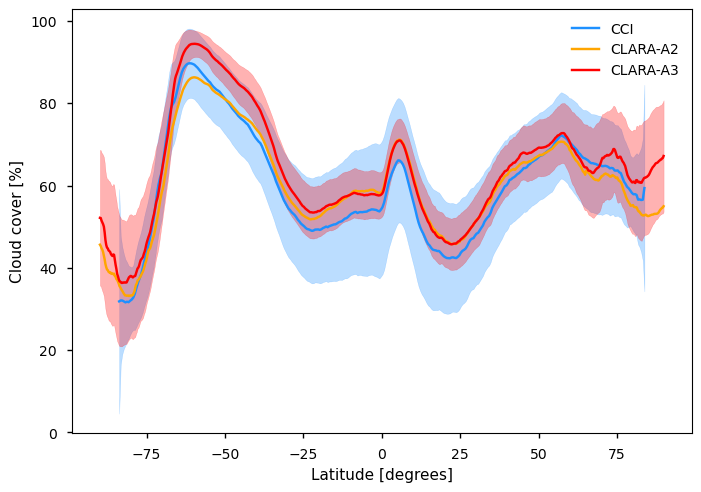

In [10]:
fig, ax = plt.subplots()
plot_latitudinal_cloud_fraction (fig, ax, DS_mean_dict)

_**Figure caption:** Latitudinal cloud fraction for the datasets CCI, CLARA-A2, and CLARA-A3, with the averages calculated for the year 2011. The solid line represents the zonal average cloud cover, while the shaded area indicates the average uncertainty across each latitudinal band. Uncertainty estimates are available for the CCI and CLARA-A3 datasets, whereas CLARA-A2 does not include uncertainty information._

The zonal annual mean cloud cover is visualized for three monthly mean datasets of CCI, CLARA-A2, and CLARA-A3. The shaded areas represent the zonal annual mean uncertainty. The plot reveals several key features worth highlighting.

The CLARA-A2 cloud cover retrieval does not provide any estimate of uncertainties.
CCI has zonal annual mean uncertainties of 10 to 15%, while CLARA-A3 has zonal annual mean uncertainties of about 5 to 10%.

The latitudinal behaviour of the three datasets is similar, with CLARA-A3 providing the largest cloud cover. Still all the three products agree within the uncertainty of CCI. The latitudinal cloud cover behaviour is also similar to the ones of the 11 datasets reported in the most recent GEWEX Cloud Assessment [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0).

The peaks and troughs in latitudinal cloud cover are influenced by global atmospheric circulation. The highest cloud cover is observed in the mid-latitudes, driven by mid and low clouds in the summer and storm clouds in the winter. The narrow peak in the deep tropics corresponds to the Intertropical Convergence Zone, which is associated with heavy precipitation. The troughs are linked to the subsidence regions in the subtropics and Antarctic.

#### Boreal Summer and Winter latitudinal cloud fraction

In [11]:
# Select only the winter months (December, January, February) and summer months (June, July, August)
winter_months = [12, 1, 2]
summer_months = [ 6, 7, 8]


DS_winter_dict = dict()
DS_summer_dict = dict()

for dataset_name, ds_ in DS_dict.items():
    DS_winter_dict[dataset_name]    = ds_.sel(time=ds_['time'].dt.month.isin(winter_months)).mean(['longitude', 'time'])
    DS_summer_dict[dataset_name]    = ds_.sel(time=ds_['time'].dt.month.isin(summer_months)).mean(['longitude', 'time'])



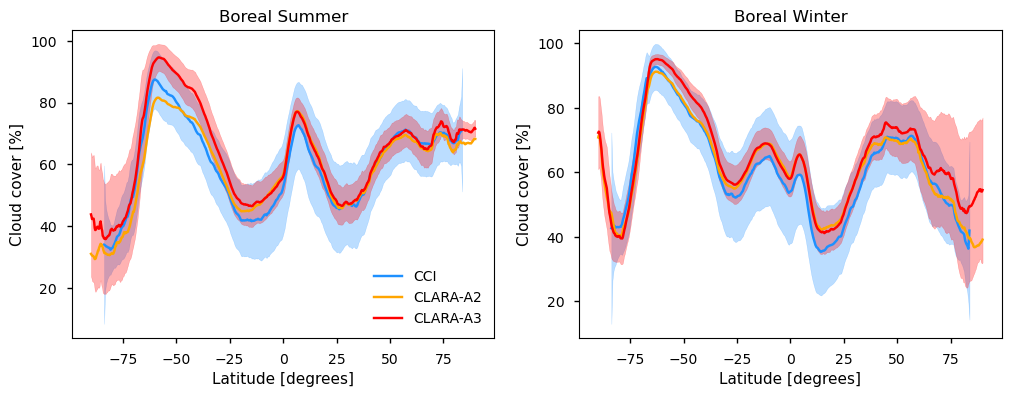

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
plot_latitudinal_cloud_fraction (fig, axs[0], DS_summer_dict, title='Boreal Summer')
plot_latitudinal_cloud_fraction (fig, axs[1], DS_winter_dict, title='Boreal Winter', legend_on=False)

_**Figure caption:** Latitudinal cloud fraction for the datasets CCI, CLARA-A2, and CLARA-A3, separately for boreal Summer (left) and Winter (right). The solid line represents the zonal average cloud fraction, while the shaded area indicates the average uncertainty across each latitudinal band._

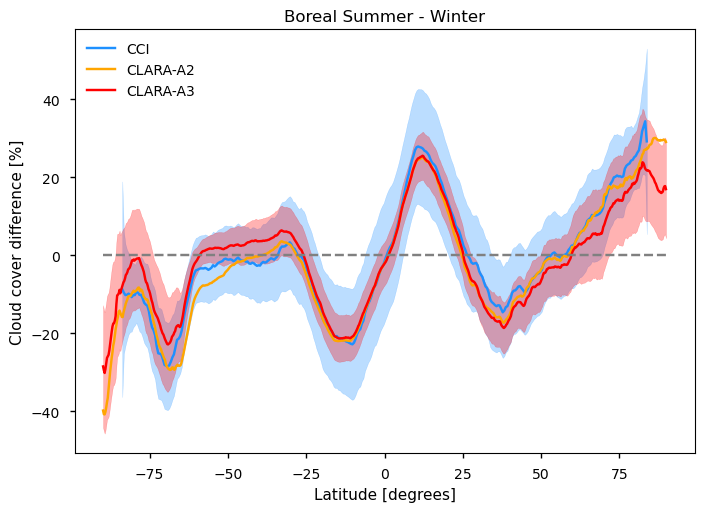

In [13]:
DS_diff = dict()
import copy
for dataset_name, ds_ in DS_dict.items():
    DS_diff[dataset_name] = copy.deepcopy(DS_winter_dict[dataset_name] )
    DS_diff[dataset_name]['cfc']  =   DS_summer_dict[dataset_name]['cfc'] - DS_winter_dict[dataset_name]['cfc']
    if dataset_name == "CLARA-A2" : continue
    DS_diff[dataset_name]['cfc_unc']  = ( DS_winter_dict[dataset_name]['cfc_unc'] + DS_summer_dict[dataset_name]['cfc_unc'] ) / 2.


fig, ax = plt.subplots()
plot_latitudinal_cloud_fraction (fig, ax, DS_diff, title='Boreal Summer - Winter', is_difference=True)

_**Figure caption:** Difference between Boreal Summer and Winter latitudinal cloud fraction for the datasets CCI, CLARA-A2, and CLARA-A3. The solid line represents the zonal average cloud fraction difference, while the shaded area indicates the average uncertainty across each latitudinal band._

The datasets again agree in their latitudinal behaviour in both seasons.

Comparing boreal summer and winter shows larger uncertainties during polar winter: The lack of illumination reduces the ability to fully exploit all AVHRR channels. Twilight conditions present further challenges due to solar contamination effect. During polar summer, under continuous illumination, the uncertainties are much smaller. In the other regions, the uncertainties are slightly larger than the annual zonal mean uncertainties.

The difference between boreal summer and winter clearly shows the displacement of the ITCZ towards the summer hemisphere in all three datasets. Furthermore, more clouds are detected in polar summer than in polar winter. In general, these seasonal differences are aligned with the ones of the datasets in the GEWEX cloud assessment, except for CALIPSO (Cloud-Aerosol Lidar and Infrared Pathfinder Satellite Observation) in the polar winter [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). The latter active instrument is more sensitive to clouds over ice and snow than passive remote sensing, in particular during nighttime [[2]](https://acp.copernicus.org/articles/10/1789/2010/).

The rapid increase of CCI uncertainty at the observed domain edges likely arises from a combination of several challenging conditions in cloud retrieval. These include the extremely high solar zenith angles in the early-morning orbit, and the decreasing accuracy of measurements near the swath edges.


#### Global maps

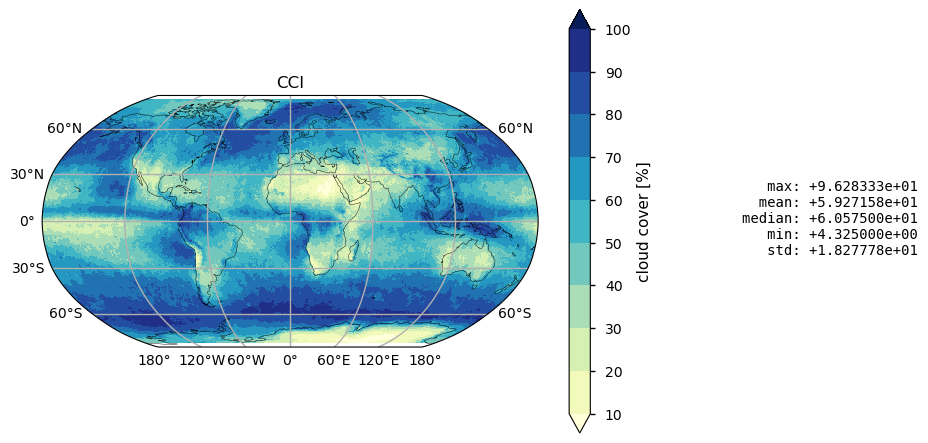

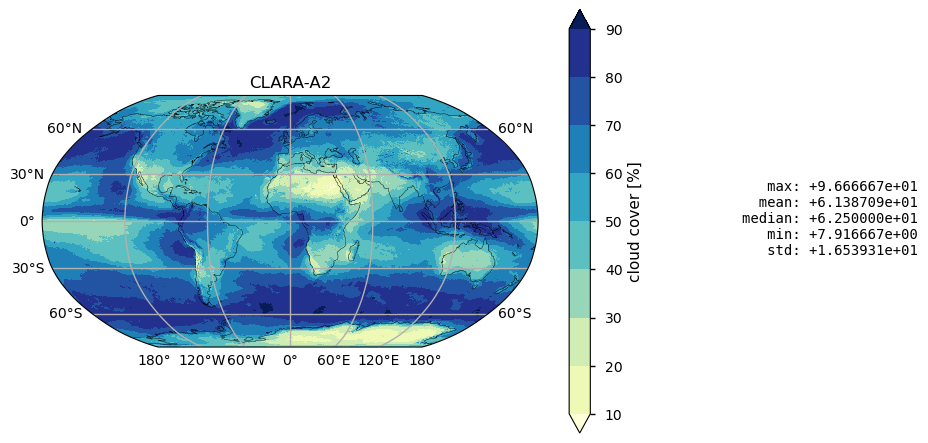

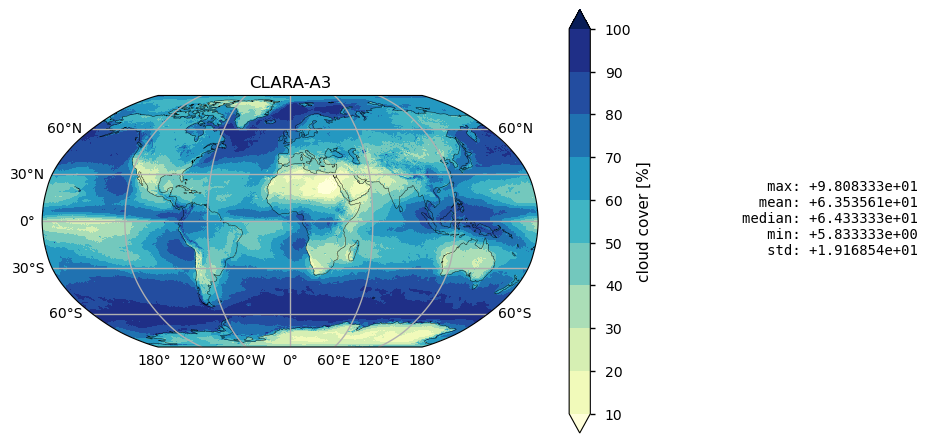

In [14]:
for dataset_name, ds_ in DS_dict.items():
    da_ = ds_.mean(['time'])['cfc']
    da_.attrs['long_name'] = 'cloud cover [%]'

    plot.projected_map(
        da_,
        projection=ccrs.Robinson(),
        cmap="YlGnBu",
        levels=9,
        robust=True,
        extend="both",
    )
    
    plt.title(dataset_name)
    plt.show()

_**Figure caption:** Cloud cover maps of the datasets CCI (top), CLARA-A2 (middle), and CLARA-A3 (bottom), calculated for the year 2011._

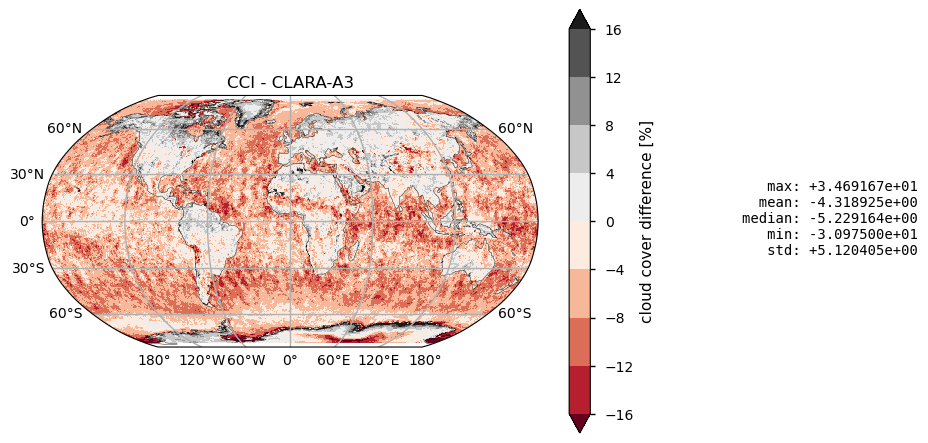

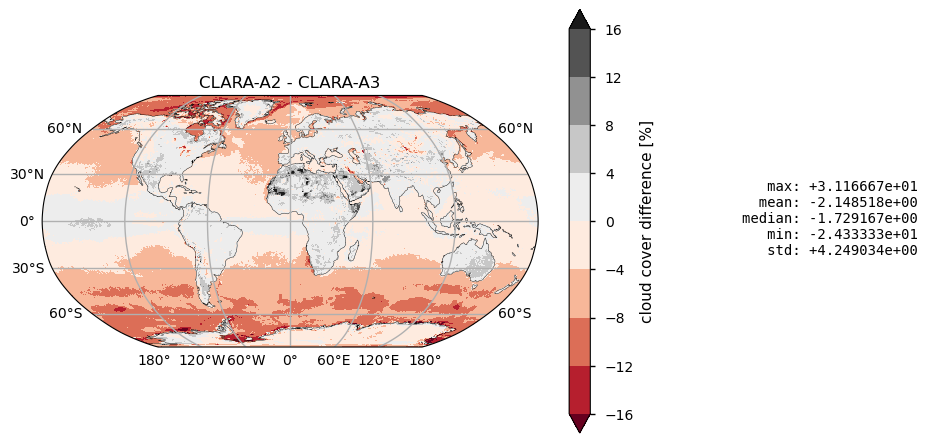

In [15]:
DS_coarsen = {'CCI' :      ds_cci,
              'CLARA-A2' : ds_clara_a2.coarsen(latitude=2, longitude=2).mean(),
          }


ds_clara_a3_coarse = ds_clara_a3.coarsen(latitude=2, longitude=2).mean()

for dataset_name, ds_ in DS_coarsen.items():
    da_ = (ds_ - ds_clara_a3_coarse).mean(['time'])['cfc']
    da_.attrs['long_name'] = 'cloud cover difference [%]'
    
    plot.projected_map(
        da_,
        projection=ccrs.Robinson(),
        cmap="RdGy",
        levels=9,
        robust=True,
        extend="both",
    )
    
    plt.title(f'{dataset_name} - CLARA-A3')
    plt.show()

_**Figure caption:** Cloud cover difference maps comparing the CCI (top) and CLARA-A2 (bottom) datasets with CLARA-A3, calculated for the year 2011. The differences are computed at a spatial resolution of 0.5 degrees._

Global means between the three datasets vary from 59.3% (CCI) to 63.5% (CLARA-A3). The latter one is within the range of the global mean of the GEWEX cloud assessment, given as 66% ± 4%.
The geographical patterns of large cloud cover show prominent features near the equator as the Inter-Tropical Convergence Zone (ITCZ), in the midlatitudes over ocean, in particular in the Southern hemisphere, given by winter storm tracks and stratocumulus and the stratocumulus regions off the western coasts in the subtropics. Prominent regions with low cloud cover are over the deserts and the subtropical ocean, in particular where one expects open cell cumulus clouds. 
However, the CCI patterns are much noisier than the ones from CLARA. This can be seen in the map differences.
The difference between CLARA-A3 and CLARA-A2 is positive over ocean, in particular at larger latitudes, and negative over land.


## ℹ️ If you want to know more
### Key resources
Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used is:
- Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations:
https://cds-beta.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview

Code libraries used:
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)


The GEWEX Cloud Assessment:
- The Global Energy and Water Exchanges (GEWEX) program is a core project of the World Climate Research Programme (WCRP). The first GEWEX Cloud Assessment was published in 2012 and it provided the first coordinated inter-comparison of publicly available, global
cloud products [[3](https://doi.org/10.1175/BAMS-D-12-00117.1)-[4](https://www.wcrp-climate.org/documents/GEWEX_Cloud_Assessment_2012.pdf)]. The database associated with the GEWEX Cloud Assessment
has revealed its usefulness for the assessment of new datasets. Since in the last decade existing
cloud property retrievals have been revised and new retrievals have been developed, this exercise has been recently repeated with 11 global cloud products derived from measurements of multi-spectral imagers, IR sounders, and lidar [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). The first cloud assessment included products from ATSR, while the most recent assessment includes CLARA-A2. However, the CLARA-A2 version (V2.1) in the CDS is a later version than the one provided in the updated GEWEX cloud assessment (V2.0), and therefore slightly improved. The updated cloud assessment database is available at [this link](https://gewexca.aeris-data.fr/).

### Reference/Useful material

[[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0) Stubenrauch, C.J., Kinne, S., Mandorli, G. et al. Lessons Learned from the Updated GEWEX Cloud Assessment Database. Surv Geophys (2024). https://doi.org/10.1007/s10712-024-09824-0

[[2]](https://acp.copernicus.org/articles/10/1789/2010/)  Karlsson, K.-G. and Dybbroe, A.: Evaluation of Arctic cloud products from the EUMETSAT Climate Monitoring Satellite Application Facility based on CALIPSO-CALIOP observations, Atmos. Chem. Phys., 10, 1789–1807, https://doi.org/10.5194/acp-10-1789-2010, 2010.

[[3]](https://doi.org/10.1175/BAMS-D-12-00117.1) Stubenrauch, C. J., and Coauthors, 2013: Assessment of Global Cloud Datasets from Satellites: Project and Database Initiated by the GEWEX Radiation Panel. Bull. Amer. Meteor. Soc., 94, 1031–1049, https://doi.org/10.1175/BAMS-D-12-00117.1. 

[[4]](https://www.wcrp-climate.org/documents/GEWEX_Cloud_Assessment_2012.pdf) Stubenrauch CJ, Rossow WB, Kinne S, GEWEX Cloud Assessment Team (2012) Assessment of Global Cloud Datasets from Satellites, A Project of the World Climate Research Programme Global Energy and Water Cycle Experiment (GEWEX) Radiation Panel, WCRP report.